## Цели и задачи проекта
Перед нами стоит задача выявить определяющие успешность игры закономерности.  Для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
В процессе проекта мы изучим динамику продаж и определим наиболее прибыльные платформы и жанры игр.
Для этого у нас имеется датасет с информацией о продажах игр с 19080 по 2016 гг в четырехх регионах - Япония, Европа, Северная Америка и Другой. 

## Шаг 1. Ознакомимся с информацией

#### Откроем данные и сохраним в датасет data

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/games.csv')

#### Взглянем на первый пять строк датафрейма data

In [27]:
print(data.head())

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  


#### Посмотрим на тип и количество данных в таблице

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Проверим количество дупликатов 

In [29]:
data.duplicated().sum()

0

Ознакомившись с данными, перейдем к их обработке: Видим, что есть пропущенные данные в столбцах с названием игры и жанром - по две строки в каждом, годом выхода - 269 строк. Также большое количество пропусков в столбцах с оценками пользователей и критиков и возрастным рейтингом, во всех количество пропусков близко к половине всех данных.

## Шаг 2. Подготовим данные

#### Приведем названия столбцов к змеиному шрифту в нижнем регистре

In [30]:
data.columns = data.columns.str.lower()
print(data.head())

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  


#### Приведем данные в столбце с оценкой пользователей к числовым значениям
В столбце есть значение tbd (to be determined), что означает, что оценки пока нет. Следовательно, мы можем заменить это значение на пропуск.

In [31]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

In [32]:
print(data.query('name.isna()'))

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN  


Две игры без названий также не имеют информации о жанре и рейтинге, удалим эти данные. Также игры, где не указан год выпуска, т.к. их чуть больше полтора процента, что существенно не повлияет на наше исследованиею А пропуски в столбце с рейтингом заменим на unknown, потому что пропуски в данном случае означают, что скорее всего рейтинг этим играм не давался


In [33]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [34]:
data = data.dropna(subset=['year_of_release'])
data['rating'] = data['rating'].fillna('unknown')

In [35]:
data = data.dropna(subset=['name'])

Пропуски в столбцах с оценкой критиков и оценкой пользователей означают, что такой оценки нет. Поэтому было бы некорректно заполнять эти данные какими либо значениями, оставим их как есть.

#### Добавим столбец с сумарным количеством продаж по всем представленым регионам.

In [36]:
data['total_sales'] = data['na_sales'] + data['eu_sales']
+ data['jp_sales'] + data['other_sales']

0        12.22
1         7.58
2         7.08
3         6.23
4        11.22
         ...  
16710     0.01
16711     0.00
16712     0.01
16713     0.00
16714     0.01
Length: 16444, dtype: float64

### Вывод по шагу 2.
На этом этапе мы изменили формат написания названий столбцов, привели данные в столбце с оценками пользователей к числовому формату. Также, мы избавились от строк, в которых отсутствовала информация об имени игры и годе выпуска, пропуски в столбце с возрастным рейтингом заменили на значение 'unknown', чтобы в дальнейшем с этими данными можно было работать.

## Шаг 3. Проведем исследовательский анализ данных

#### Посмотрим на количестов игр, выпускаемых по годам

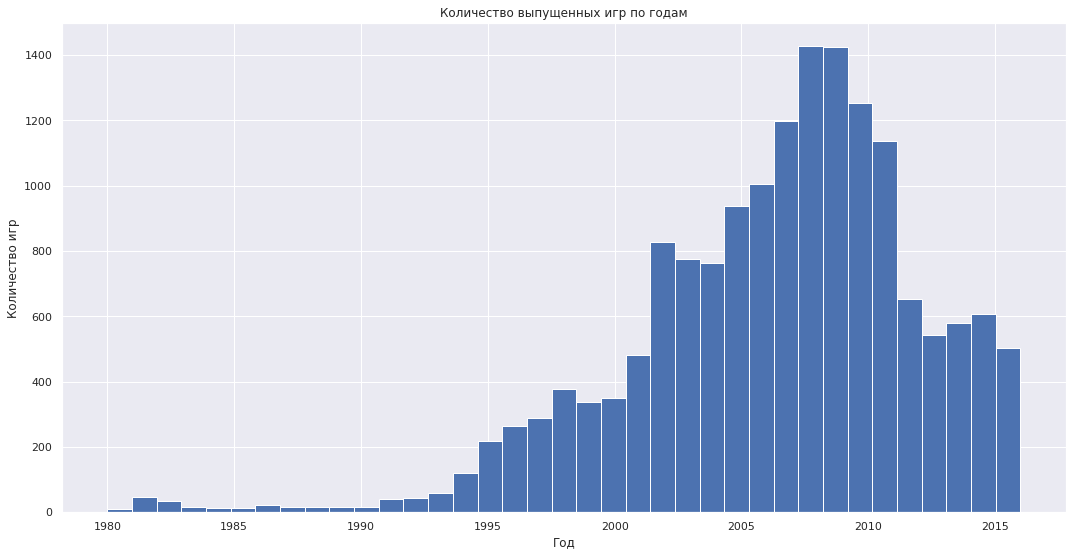

In [37]:
data['year_of_release'].hist(
    bins=37, 
    figsize=(18,9), 
);
plt.xlabel("Год")
plt.ylabel("Количество игр")
plt.title('Количество выпущенных игр по годам')
plt.show()

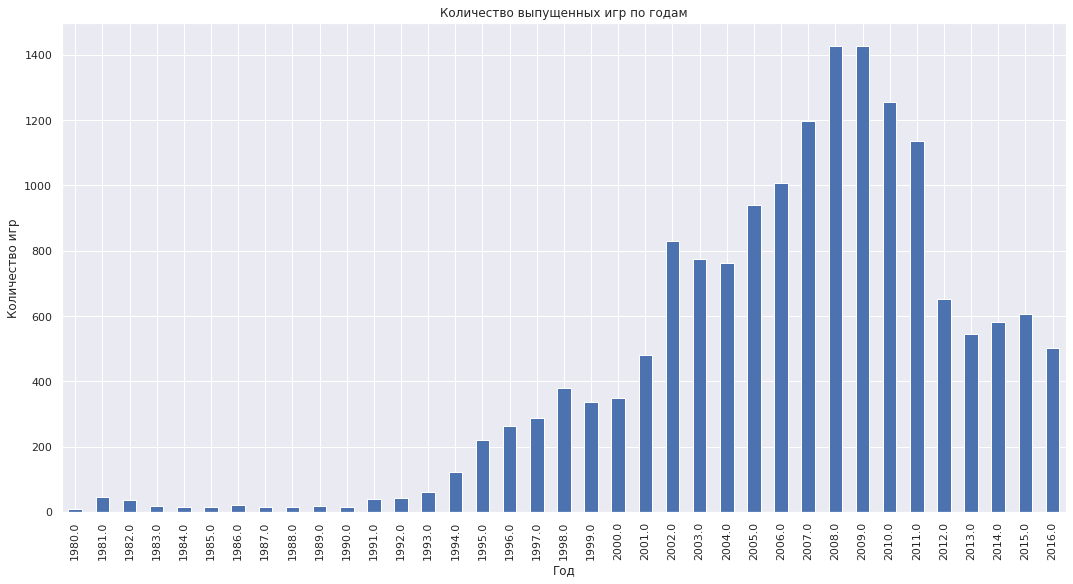

In [38]:
games_per_year = data['year_of_release'].value_counts().sort_index()

games_per_year.plot(kind='bar', figsize=(18,9));
plt.xlabel("Год")
plt.ylabel("Количество игр")
plt.title('Количество выпущенных игр по годам')
plt.show()

In [39]:
print((data.query('year_of_release<1996')['platform'].count()/data['platform'].count()))

0.04287278034541474


Общее количество игр, выпущеных до 1995 года не превышает 5% и из графика видно, что количество игр выпущеных в эти года значительно меньше количества последующих годов. В 2002 году развитие игровой индустрии совершило скачок ис тех пор ежегодно производится в среднем более 800 игр в год.
Сосредоточимся на данных после 1995 года

In [40]:
data = data.query('year_of_release>1995')

#### Теперь посмотрим на 10 наиболее популярных платформ с помощью сводной таблицы

In [41]:
sales_platform = data.pivot_table(index='platform', values='total_sales', aggfunc=('sum')).sort_values(by='total_sales', ascending=False)
print(sales_platform.head(10))

          total_sales
platform             
PS2            905.55
X360           864.06
Wii            745.19
PS3            717.34
DS             568.72
PS             519.69
GBA            258.71
PS4            249.83
XB             241.71
PC             214.34


In [42]:
sales_top = data[data['platform'].isin(sales_platform.head(10).index)]

#### Посмотрим как долго остаются популярными разные платформы

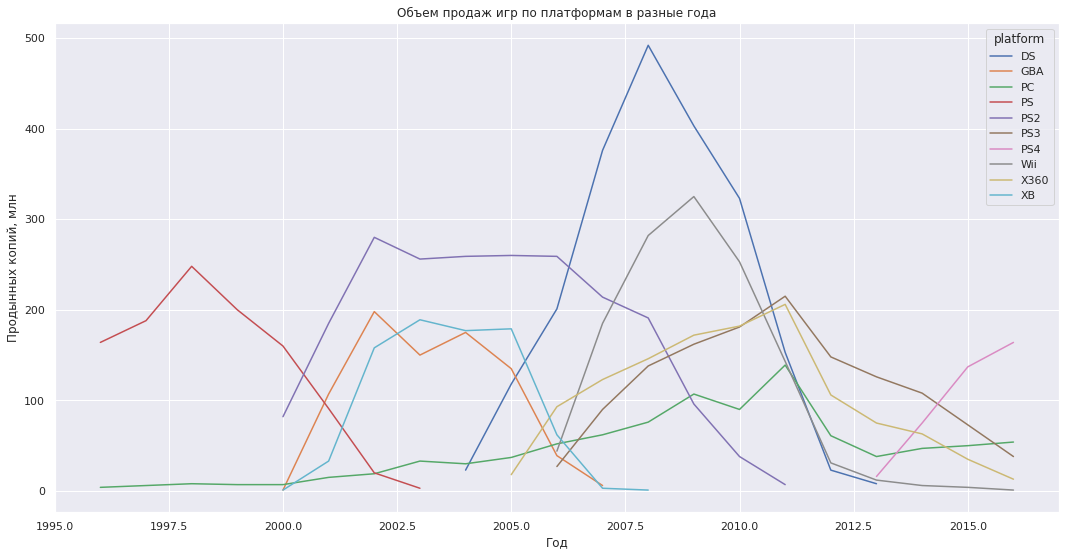

In [43]:
sales_top.groupby(
    ['platform', 'year_of_release']
)['total_sales'].count().unstack('platform').plot(figsize=(18,9));
plt.xlabel("Год")
plt.ylabel("Продынных копий, млн")
plt.title('Объем продаж игр по платформам в разные года')
plt.show()

Из графика видим, что "продолжительность жизни" платформы в среднем представляет 7-10 лет. При этом, основная доля продаж приходится зачастую на 5 лет. Возьмем этот промежуток как жизненый цикл платформы.

Исключение составляет, ожидаемо, PC, что не учитывает различные операционные системы и их обновления.

Можно также заметить, что наибольшее количество консолей появилось в промежутке 2004-2006 гг.

Учитывая, что мы строим прогноз на 2017 год, данные до 2011 года не будут для нас информативными.

In [44]:
data_last = data.query('year_of_release>2010')

#### Посмотрим на динамику популярности платформ с 2011 по 2016 год

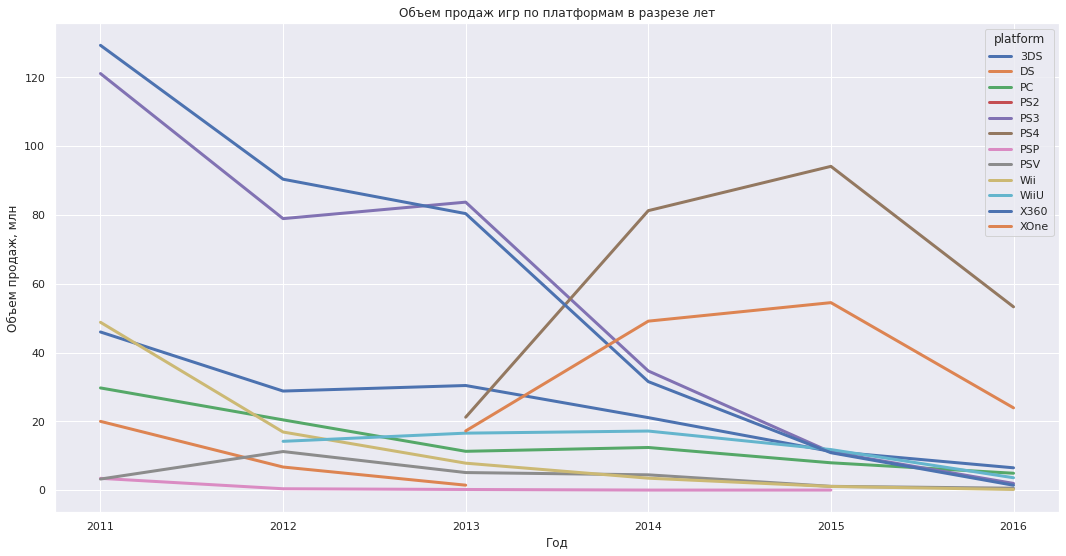

In [45]:
data_last.groupby(
    ['platform', 'year_of_release']
)['total_sales'].sum().unstack('platform').plot(
    figsize=(18,9), 
    grid=True,
    linewidth = 3,
    title = 'Объем продаж игр по платформам в разрезе лет',
    xlabel = 'Год',
    ylabel = 'Объем продаж, млн'
    
);


Из графика выше мы можем видеть, что наиболее популярные платформы за 2014-2016 по количеству проданных игр - это XOne и PS4. 

Даже при условии, что продажи по ним падают, остальные платформы сильно от них отстают.

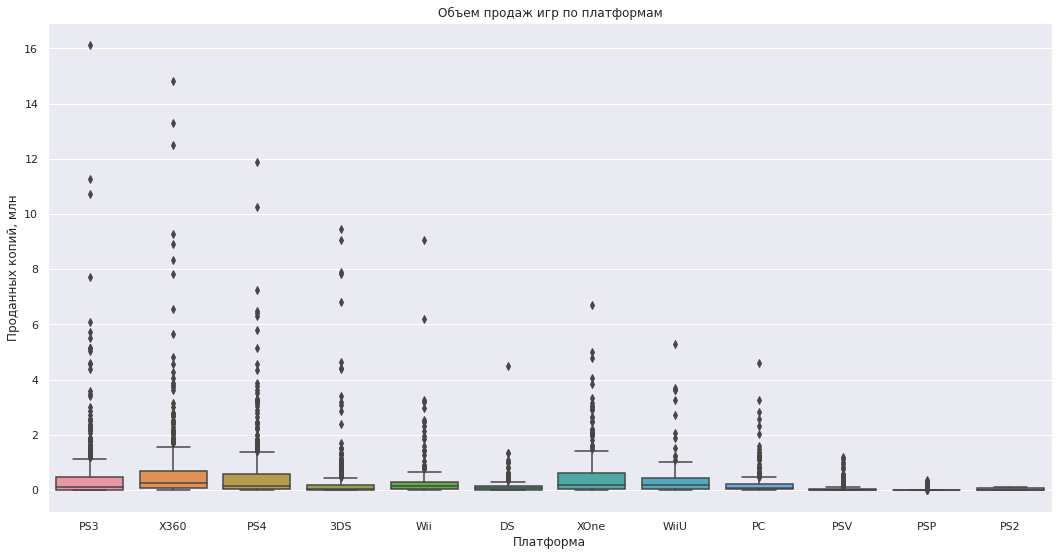

In [49]:
sns.boxplot(data=data_last,         
         x='platform',
         y='total_sales',
);
sns.set(rc={'figure.figsize':(18,9)})

plt.title('Объем продаж игр по платформам')
plt.xlabel("Платформа")
plt.ylabel("Проданных копий, млн")
plt.show()

Из графика видим, что у лидеров продаж есть отдельные выбивающиеся значения, которые сильно влияют на статистику. Это игры-бестселлеры. Посмотрим на значения квартилей поближе, ограничив верхнюю границу графиков значением 1.6 млн.

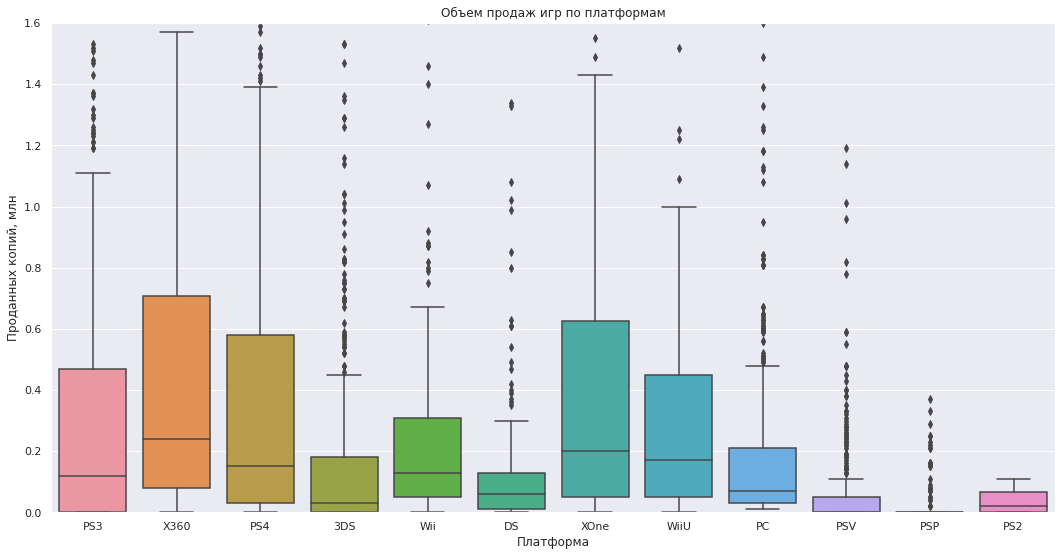

In [50]:
sns.boxplot(data=data_last,         
         x='platform',
         y='total_sales',
);
sns.set(rc={'figure.figsize':(18,9)})
plt.ylim(0,1.6);

plt.title('Объем продаж игр по платформам')
plt.xlabel("Платформа")
plt.ylabel("Проданных копий, млн")
plt.show()

В большинстве случаев медианные значения продаж, из чего я могу сделать вывод, что в этих данных очень много выбросов - игр бестселлеров. Также, могу предложить, что именно они и составляют основную массу проданных игр. 
Сравним показатели X360 и XOne. У них близкие медианные значения и значения, однако, у XOne гораздо меньше выбросов, что говорит о более равномерном распределении продаж игр на XOne.
Также, продажи игр на платформах близки  PS3 и PS4 по значению медианы и примерному распределению данных.

#### Посмотрим на зависимость количества покупок от оценок пользователей и критиков.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Корреляция между количеством покупок и оценкой пользователей: 0.037903660587732896
Корреляция между количеством покупок и оценкой критиков: 0.390462477406671


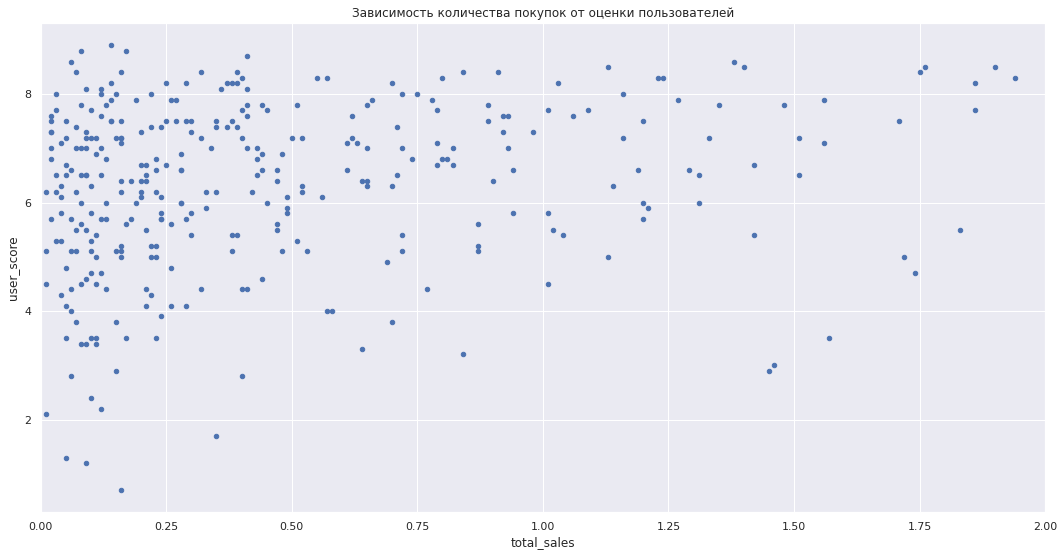

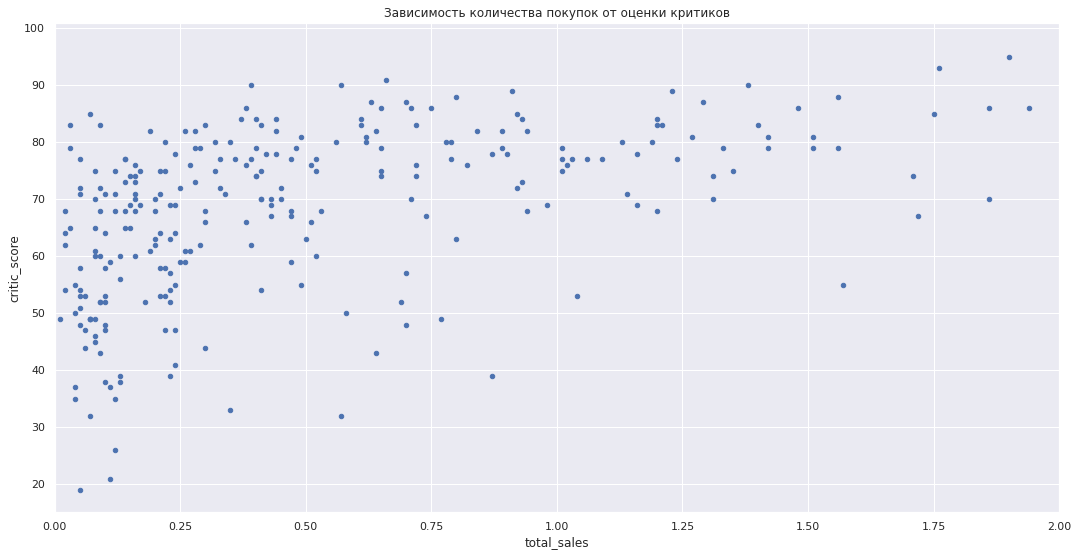

In [63]:
data_x360 = data_last.query('platform=="X360"')
print(f"Корреляция между объемом продаж и оценкой пользователей: {data_x360['total_sales'].corr(data_x360['user_score'])}")
print(f"Корреляция между объемом продаж и оценкой критиков: {data_x360['total_sales'].corr(data_x360['critic_score'])}")
data_x360.plot(x='total_sales', y='user_score', kind='scatter', title="Зависимость продаж от оценки пользователей");
plt.xlim(0,2);

data_x360.plot(x='total_sales', y='critic_score', kind='scatter', title="Зависимость продаж от оценки критиков");
plt.xlim(0,2);


Выходит, потенциальные покупатели игр на платформе X360 больше доверяют экспертам, чем другим игрокам. Тем не менее, корреляция очень слабая, что также подтверждается графиками. Посмотрим, как обстоят дела с остальными платформами.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Корреляция между количеством покупок и оценкой пользователей: 0.010211801441615835
Корреляция между количеством покупок и оценкой критиков: 0.3295240165286159


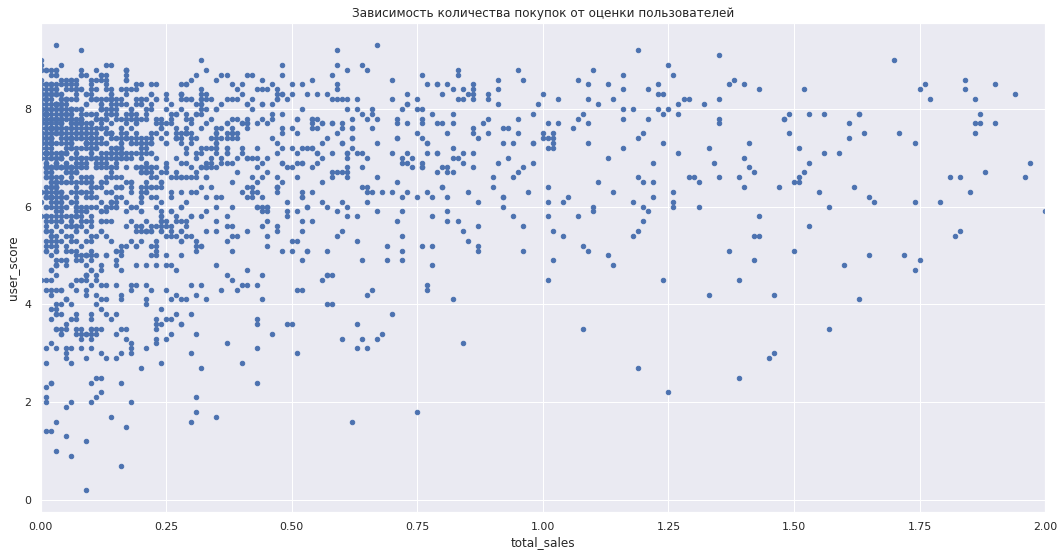

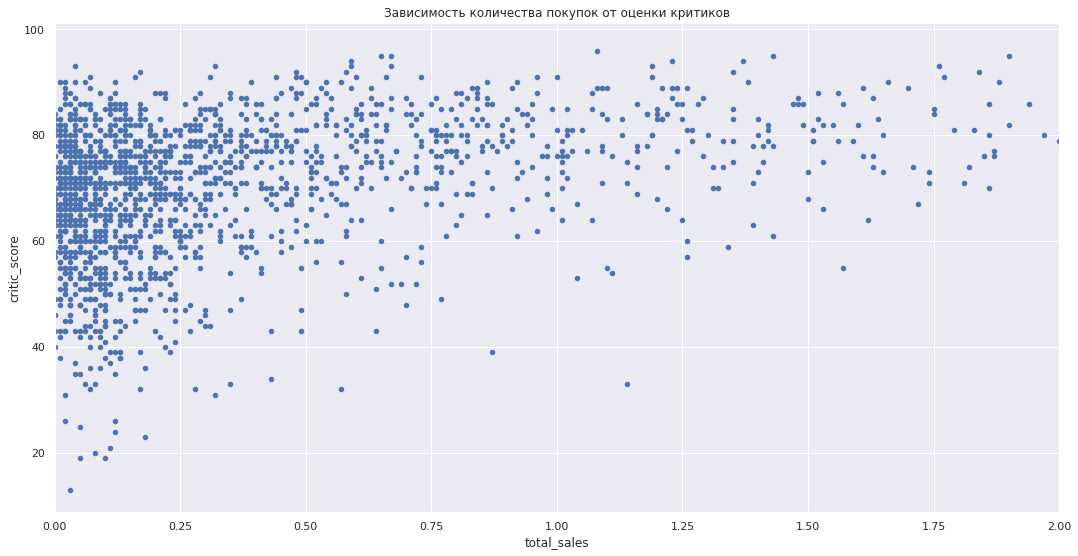

In [64]:

print(f"Корреляция между количеством покупок и оценкой пользователей: {data_last['total_sales'].corr(data_last['user_score'])}")
print(f"Корреляция между количеством покупок и оценкой критиков: {data_last['total_sales'].corr(data_last['critic_score'])}")
data_last.plot(
    x='total_sales', 
    y='user_score', 
    kind='scatter', 
    title="Зависимость количества покупок от оценки пользователей"
);
plt.xlim(0,2);

data_last.plot(
    x='total_sales', 
    y='critic_score', 
    kind='scatter', 
    title="Зависимость количества покупок от оценки критиков"
);
plt.xlim(0,2);

Мы видим, что корреляция продаж с оценками критиков и игроков для всех платформ еще ниже, из чего можно сделать вывод, что отзывы не влияют на колличество продаж.

Посмотрим на то, как покупают игры разных жанров

In [61]:
sales_genre = data_last.pivot_table(
    index='genre', 
    values='total_sales', 
    aggfunc= ('mean', 'sum', 'count', 'median')
).sort_values(by='median', ascending=False)
print(sales_genre)
#sales_genre.columns = ['genre', 'mean', 'sum', 'count', 'median']
#   


              count      mean  median     sum
genre                                        
Shooter         329  1.040881    0.35  342.45
Sports          389  0.506889    0.16  197.18
Platform        122  0.560246    0.16   68.35
Racing          180  0.403111    0.12   72.56
Fighting        159  0.301069    0.09   47.87
Misc            375  0.291760    0.09  109.41
Simulation      136  0.258015    0.08   35.09
Action         1269  0.338881    0.07  430.04
Puzzle           71  0.088732    0.03    6.30
Role-Playing    465  0.314151    0.03  146.08
Strategy        117  0.132479    0.02   15.50
Adventure       410  0.070049    0.00   28.72


Чаще всего ироки покупают игры в жанре "экшн", что, очевино, известно производителям игр, ведь количество игр этого жанра значительно больше, чем всех остальных.

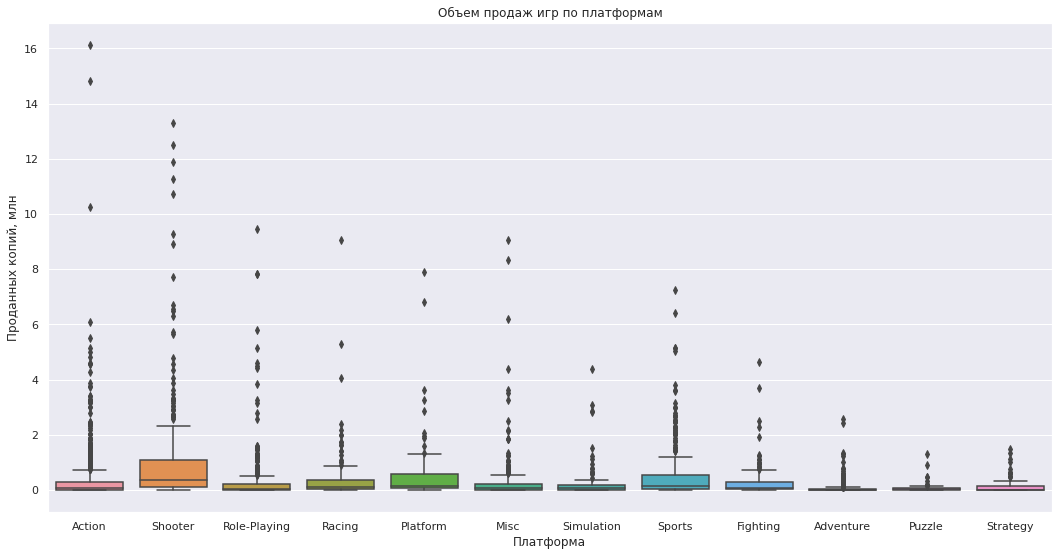

In [64]:
sns.boxplot(data=data_last,         
         x='genre',
         y='total_sales',
);
sns.set(rc={'figure.figsize':(18,9)})
#plt.ylim(0,4);

plt.title('Объем продаж игр по жанрам')
plt.xlabel("Жанр")
plt.ylabel("Проданных копий, млн")
plt.show()

Из графика выше видно, что жанр "экшн" - бесспорный лидер по количеству выбросов.
Посмотрим на график поближе

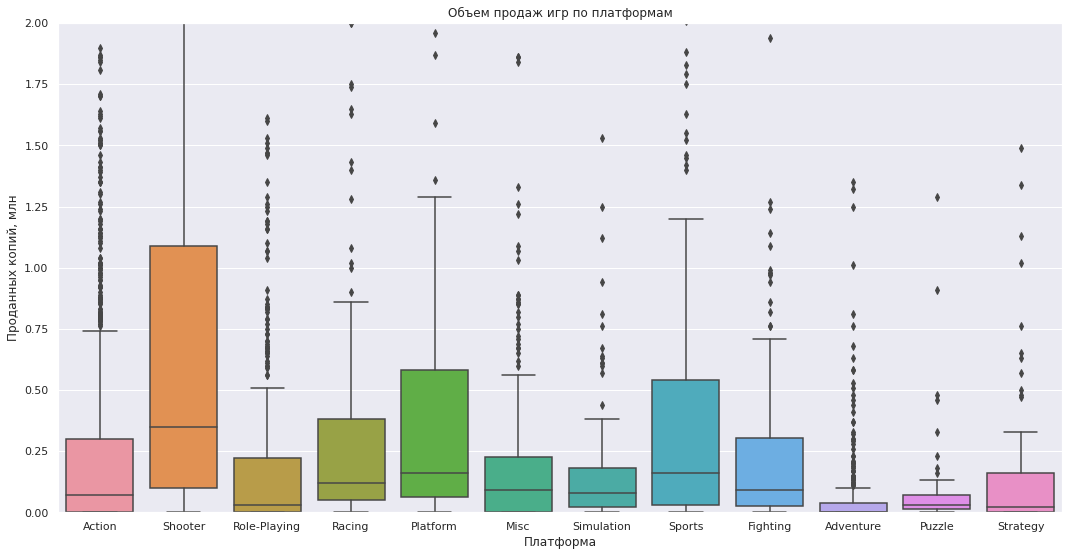

In [66]:
sns.boxplot(data=data_last,         
         x='genre',
         y='total_sales',
);
sns.set(rc={'figure.figsize':(18,9)})
plt.ylim(0,2);

plt.title('Объем продаж игр по платформам')
plt.xlabel("Платформа")
plt.ylabel("Проданных копий, млн")
plt.show()

При более близком рассмотрении, видно, что хоть "экшн" и лидирует в абсолютных значениях, "шутеры" приносят гораздо более стабильные продажи.

### Вывод по шагу 3.
В 2002 году развитие игровой индустрии совершило скачок и с тех пор ежегодно производится в среднем более 800 игр в год. В 2004-2006 гг появилось большое количество новых платформ и, как результат в 2007-2010 гг мы видим еще один всплеск количества новых игр.

"Продолжительность жизни" платформы в среднем представляет 7-10 лет. При этом, основная доля продаж приходится зачастую на 5 лет. 

Наиболее популярные платформы за 2014-2016 по количеству проданных игр - это XOne и PS4. Даже при условии, что продажи по ним падают, остальные платформы не могут с ними сравниться по продажам за этот период.

Выходит, потенциальные покупатели игр на платформе X360 больше доверяют экспертам, чем другим игрокам. Тем не менее, корреляция очень слабая, что также подтверждается графиками. Посмотрим, как обстоят дела с остальными платформами.

Мною не была обнаружена связь между оценками пользователей и продажами и была обнаружена слабая связь между продажами и оценками критиков.

Самыми популярними оказались игры в жанре "экшн", при чем и по количеству купленых и по количеству произведеных игр.
На втором месте по продажам игры жанра "шутер", отставая на 20% от лидера. Тем не менее, хоть "экшн" и лидирует в абсолютных значениях, "шутеры" приносят гораздо более стабильные продажи. При этом, количество выпущеных игр в этом жанре почти в 4 раза меньше.

## Шаг 4. Составим портрет пользователя каждого региона

### Посмотрим на то, какие платформы и жанры наиболее популярны а также влияет ли рейтинг ESRB на продажи в разных регионах.

#### Начнем с Японии

In [66]:
platform_sales_jp = data_last.pivot_table(
    index='platform', 
    values='jp_sales',
    aggfunc='sum'
    
).sort_values(by='jp_sales', ascending=False)
display(platform_sales_jp.head())

genre_sales_jp = data_last.pivot_table(
    index='genre', 
    values='jp_sales',
    aggfunc='sum'
    
).sort_values(by='jp_sales', ascending=False)
display(genre_sales_jp.head())

rating_sales_jp = data_last.pivot_table(
    index='rating', 
    values='jp_sales',
    aggfunc='sum'
).sort_values(by='jp_sales', ascending=False)
display(rating_sales_jp)

,jp_sales
platform,
3DS,100.62
PS3,49.39
PSP,24.04
PSV,21.84
PS4,15.96


,jp_sales
genre,
Role-Playing,79.87
Action,63.62
Misc,17.60
Fighting,12.38
Platform,12.13


,jp_sales
rating,
unknown,138.21
E,36.68
T,33.39
M,26.14
E10+,11.23
EC,0.00
RP,0.00


Из данных выше видим что самая популярная платформа в Японии - 3DS, игры на нее покупают в два раза чаще, чем на PS3 и в четыре раза чаще, чем на PSP.
Самый популярный жанр - "ролевая" и на втором месте "экшн", все остальные жанры не пользуются популярностью.
болше половины купленых игр не имеют рейтинга, скорее всего это локальные игры и ESRB не дает им рейтинг.

In [67]:
platform_sales_na = data_last.pivot_table(
    index='platform', 
    values='na_sales',
    aggfunc='sum'
    
).sort_values(by='na_sales', ascending=False)
display(platform_sales_na.head())

genre_sales_na = data_last.pivot_table(
    index='genre', 
    values='na_sales',
    aggfunc='sum'
    
).sort_values(by='na_sales', ascending=False)
display(genre_sales_na.head())

rating_sales_na = data_last.pivot_table(
    index='rating', 
    values='na_sales',
    aggfunc='sum'
    
).sort_values(by='na_sales', ascending=False)
display(rating_sales_na.head())

,na_sales
platform,
X360,226.80
PS3,168.26
PS4,108.74
XOne,93.12
3DS,82.65


,na_sales
genre,
Action,230.92
Shooter,194.43
Sports,108.70
Role-Playing,83.78
Misc,69.69


,na_sales
rating,
M,308.45
E,170.17
unknown,123.69
E10+,117.72
T,109.31


Самая популярная платформа в Северной Америке X360 - 226 млн. проданных игр, за ней следуют PS3 и PS4 с продажами 168 и 108 млн. копий соответственно. 
Наиболее популярные жанры - "экшн" и "шутер" - 230 и 194 млн. копий соответственно.
Преобладают покупки игр для взрослой аудитории, их куплено почти в два раза больше, чем игр "для всех".

In [68]:
platform_sales_eu = data_last.pivot_table(
    index='platform', 
    values='eu_sales',
    aggfunc='sum'
    
).sort_values(by='eu_sales', ascending=False)
display(platform_sales_eu.head())

genre_sales_eu = data_last.pivot_table(
    index='genre', 
    values='eu_sales',
    aggfunc='sum'
    
).sort_values(by='eu_sales', ascending=False)
display(genre_sales_eu.head())

rating_sales_eu = data_last.pivot_table(
    index='rating', 
    values='eu_sales',
    aggfunc='sum'
    
).sort_values(by='eu_sales', ascending=False)
display(rating_sales_eu.head())

,eu_sales
platform,
PS3,163.10
PS4,141.09
X360,117.10
3DS,61.27
PC,56.70


,eu_sales
genre,
Action,199.12
Shooter,148.02
Sports,88.48
Role-Playing,62.30
Racing,40.58


,eu_sales
rating,
M,250.26
E,141.73
unknown,116.61
T,83.16
E10+,78.00


В Европе лидеры по платформам - PS3 PS4 и X360 с показателями 163, 141 и 117 млн. копий соответственно. Остальные платформы гораздо менее популярны.
Наиболее популярные жанры - "экшн" и "шутер" - 199 и 148 млн. копий соответственно. Остальные жанры сильно отстают от них.
Так же, как и Северной Америке, здесь преобладают покупки игр для взрослой аудитории, их куплено 250 млн. копий, а игр "для всех" - 141 млн. копий. Соотношение покупок также похоже на соотношение в Северной Америке.

### Вывод по шагу 4.
Северная Америка и Европа очень похожи по тому, какие игры они выбирают и на чем в них играют, так, в этих ренионах самые популярные платформы в порядке убывания популярности - X360, PS3 и PS4.

Наиболее популярные жанры - "экшн" и "шутер" и преобладают покупки игр для взрослой аудитории, их куплено почти в два раза больше, чем игр "для всех".

В Японии ситуация очень сильно отличается от двух других территорий. Здесь самая популярная платформа - 3DS, игры на нее покупают в два раза чаще, чем на PS3 и в четыре раза чаще, чем на PSP.
Самый популярный жанр - "ролевая" и на втором месте "экшн", все остальные жанры не пользуются популярностью. 

Также, я предполагаю, что играм в Японии не присваевается рейтинг возрастной рейтинг.

## Шаг 5. Проверим гипотезы

#### Проверим, отличаются ли оценка пользователей, играющих на РС и на XOne .
Предположим, что средние пользовательские рейтинги у обеих платформ одинаковые и проведем исследование этой вероятности с помощью t-теста.
За нулевую гипотезу примем, что рейтинги одинаковые, а за альтернативную, что разные:

Н0 - У игр на PC и XOne в среднем одинаковая оценка

H1 - Оценка не одинаковая.


In [69]:
from scipy import stats as st


alpha = .01 

results = st.ttest_ind(
     data_last[(data_last['platform'] == 'PC')& (data_last['user_score']>0)]['user_score'],
     data_last[(data_last['platform'] == 'XOne')& (data_last['user_score']>0)]['user_score'],
    
    
)



print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.6267602271422398
Не получилось отвергнуть нулевую гипотезу


Как мы и предполагали, в основном средние рейтинги  у обеих платформ одинаковые

#### Проверим, отличаются ли оценка пользователей, играющих в спортивные и экшн игры. 
Предположим, что средние пользовательские рейтинги у этих жанров разные и проведем исследование этой вероятности с помощью t-теста.
За нулевую гипотезу примем, что рейтинги одинаковые, а за альтернативную, что разные

Н0 - У игр В жанре Sports и Action в среднем одинаковая оценка

H1 - Оценка не одинаковая.


In [70]:

alpha = .01 


results = st.ttest_ind(
     data_last[(data_last['genre'] == 'Sports')& (data_last['user_score']>0)]['user_score'], 
     data_last[(data_last['genre'] == 'Action')& (data_last['user_score']>0)]['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.1974550252152054e-24
Отвергаем нулевую гипотезу


И снова мы оказались правы, средние рейтинги игроков разные

## Вывод

Перед нами стояла задача выявить определяющие успешность игры закономерности.  Для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В процессе предобработки данных мы изменили формат написания названий столбцов, привели данные в столбце с оценками пользователей к числовому формату. Также, мы избавились от строк, в которых отсутствовала информация об имени игры и годе выпуска, пропуски в столбце с возрастным рейтингом заменили на значение 'unknown'.

"Продолжительность жизни" платформы в среднем представляет 7-10 лет. При этом, основная доля продаж приходится зачастую на 5 лет. Поэтому было принято решение работать с данными за последние 5 лет 

Наиболее популярные платформы за 2014-2016 по количеству проданных игр - это XOne и PS4. Даже при условии, что продажи по ним падают, остальные платформы не могут с ними сравниться по продажам за этот период.


Мною не была обнаружена связь между оценками пользователей и продажами и была обнаружена слабая связь между продажами и оценками критиков. Выходит, потенциальные покупатели игр на платформе X360 больше доверяют экспертам, чем другим игрокам. Тем не менее, корреляция очень слабая, что также подтверждается графиками. Посмотрим, как обстоят дела с остальными платформами.

Самыми популярними казались игры в жанре "экшн", при чем и по количеству купленых и по количеству произведеных игр. 
На втором месте по продажам игры жанра "шутер", отставая на 20% от лидера. При этом, количество выпущеных игр в это жанре почти в 4 раза меньше.
Северная Америка и Европа очень похожи по тому, какие игры они выбирают и на чем в них играют, так, в этих ренионах самые популярные платформы в порядке убывания популярности - X360, PS3 и PS4.

Наиболее популярные жанры - "экшн" и "шутер" и преобладают покупки игр для взрослой аудитории, их куплено почти в два раза больше, чем игр "для всех".

В Японии ситуация очень сильно отличается от двух других территорий. Здесь самая популярная платформа - 3DS, игры на нее покупают в два раза чаще, чем на PS3 и в четыре раза чаще, чем на PSP.
Самый популярный жанр - "ролевая" и на втором месте "экшн", все остальные жанры не пользуются популярностью. 

Также, я предполагаю, что играм в Японии не присваевается рейтинг возрастной рейтинг.